# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [49]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import barplot,countplot
import matplotlib.pyplot as plt


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score


In [5]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Identify Features") \
    .getOrCreate()

df = spark.read.json('mini_sparkify_event_data.json')

# Print schema for future reference
df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
#clean dataset with empty userid
df = df.filter(df.userId != "")
print(f"Empty userIds: {df.filter(df.userId == '').count()}")

Empty userIds: 0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [7]:
# observation
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Look at first 5 rows for sample
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# Amount of users 
df.select("userId").dropDuplicates().count()

225

In [10]:
# Amount of sessions
df.select("sessionId").dropDuplicates().count()

2312

In [11]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [12]:
#Distribution of user downgrades and cancellations
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled').describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|        downgraded|         cancelled|
+-------+------------------+------------------+------------------+
|  count|               225|               225|               225|
|   mean|65391.013333333336|              0.28|0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736184|0.4224832108996327|
|    min|                10|                 0|                 0|
|    max|                99|                 3|                 1|
+-------+------------------+------------------+------------------+



In [13]:
windowvalue = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)


df = df.withColumn("churn_phase", Fsum("cancelled").over(windowvalue))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowvalue))

In [14]:
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [15]:
song=udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
df = df.withColumn('date', get_day(col('ts')))

In [16]:
df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [17]:
days = lambda i: i * 86400 
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [18]:
#number of songs played daily
df.filter((df.page=='NextSong')&(col('churn_phase')==1)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

df.filter((df.page=='NextSong')&(col('churn_phase')==0)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037885|71.24764235703725|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493976|74.02407951472078|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



In [19]:
#number of songs couldn't be played due to errors
df.filter((df.page=='Error')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

df.filter((df.page=='Error')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

+-------+------------------+
|summary|       count(page)|
+-------+------------------+
|  count|                30|
|   mean|1.0666666666666667|
| stddev|0.2537081317024624|
|    min|                 1|
|    max|                 2|
+-------+------------------+

+-------+-------------------+
|summary|        count(page)|
+-------+-------------------+
|  count|                200|
|   mean|                1.1|
| stddev|0.31702131247412063|
|    min|                  1|
|    max|                  3|
+-------+-------------------+



In [20]:
#who cancelled subscriptions both free and paid
print(df.filter((df.page=='Cancellation Confirmation') & (df.level=='paid')).count(),
df.filter((df.page=='Cancellation Confirmation') & (df.level=='free')).count())

31 21


In [21]:
#number of users who downgraded
#number of users to cancel
print(df.filter(col('downgraded')==1).select('userId').dropDuplicates().count(), 
      df.filter(col('cancelled')==1).select('userId').dropDuplicates().count())

49 52


In [22]:
#users who downgraded and cancelled
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==1)&(col("cancelled")==1))\
    .count()

9

In [24]:
#number of times user opted for help
df.filter((df.page=='Help')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

df.filter((df.page=='Help')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

+-------+-----------------+------------------+
|summary|           userId|       count(page)|
+-------+-----------------+------------------+
|  count|              171|               171|
|   mean|62613.21052631579|1.3976608187134503|
| stddev| 88778.9002607509|0.8078987426633197|
|    min|           100001|                 1|
|    max|               87|                 6|
+-------+-----------------+------------------+

+-------+------------------+------------------+
|summary|            userId|       count(page)|
+-------+------------------+------------------+
|  count|               816|               816|
|   mean| 63176.38602941176|1.4889705882352942|
| stddev|115512.27837413888|0.8636495080491383|
|    min|                10|                 1|
|    max|                99|                 8|
+-------+------------------+------------------+



In [25]:
#number of users to cancel w/o downgrade
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

In [26]:
#number of paid users to drop without downgrading -> big chunk of those
print(df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [27]:
#find those who done have diff listening habits?
df.filter(col('cancelled')==1).agg({'length':'mean'}).show()
df.filter(col('cancelled')==0).agg({'length':'mean'}).show()

+-----------+
|avg(length)|
+-----------+
|       null|
+-----------+

+-----------------+
|      avg(length)|
+-----------------+
|249.1171819778458|
+-----------------+



UsageError: Line magic function `%matplot` not found.


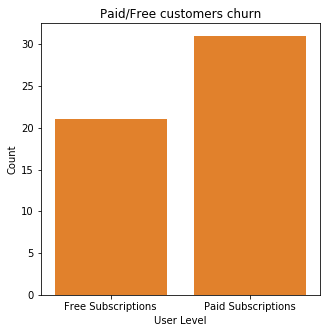

In [28]:
# Plotting a bar plot to show difference between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(5, 5))

df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[1])

ax.set(xticklabels=['Free Subscriptions', 'Paid Subscriptions'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

%matplot plt

In [29]:
# Drop missing userId and sessionId
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [30]:
# add downgrade flag
df = df.withColumn('downgrade', when(df.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))

# add churn
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))


UsageError: Line magic function `%matplot` not found.


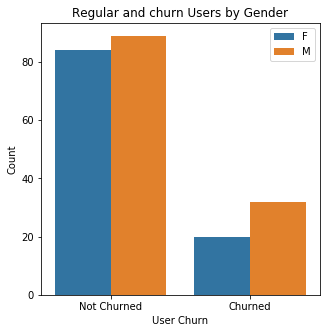

In [31]:
churn_gender_df = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().toPandas()
churn_gender_df



# Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(5, 5))
plt.title('Regular and churn Users by Gender')
ax = sns.barplot(x = 'user_churn', y = 'count', data = churn_gender_df, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [32]:
def feature_engineering(filepath):
    '''
    Create necessary features to use machine learning algorithms.
    First loads data set from file
    
    Resulting DF Strucutre:
    
    root
     |-- userId: string
     |-- downgraded: long
     |-- cancelled: long
     |-- visited_cancel: long
     |-- visited_downgrade: long
     |-- dailyHelpVisits: double
     |-- dailyErrors: double
     |-- free: integer
     |-- paid: integer
     |-- avgThumbsUp: double
     |-- avgThumbsDOwn: double
     |-- numFriends: long
     |-- avgSongsTillHome: double
     |-- avgTimeSkipped: double
     |-- skipRate: double
    
    Inputs
        filepath (str) - path to json dataset on file
        
    Outputs
        data - engineered dataset
    '''
    #dataframe of user ids to merge onto
    df = spark.read.json(filepath)
    users = df.where((df.userId != "") | (df.sessionId != ""))\
        .select('userId').dropDuplicates()
    
    #define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    song = udf(lambda x: int(x=='NextSong'), IntegerType())
    days = lambda i: i * 86400 
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    skipped = udf(lambda x: int(x!=0), IntegerType())
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())
    
    #define windows
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
    daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts'))\
        .rangeBetween(Window.unboundedPreceding, 0)

    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')
    
    avgThumbsDown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown')
    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    '''
    process for calculating skipping variables

    1. dont include thumbs up and down pages because that usually occurs 
        while playing and does not change song
    2. create variable for if action is song
    3. check if next action is song - this will check to see if someone is 
        skipping song or just leaving page
    4. get the difference in timestamp for next action song playing
    5. subtract the difference in timestamp from song length to see 
        how much of song was skipped
    6. get descriptive stats
    '''

    skipping = df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
        .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
        .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
        .withColumn('nextActSong', lag(col('song')).over(session))\
        .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
        .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
        .withColumn('roundedLength', floor('length'))\
        .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
        .withColumn('skipped', skipped('timeSkipped'))\
        .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
        .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
        .withColumnRenamed('avg(skipped)', 'skipRate')\
        .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')
    
#avg daily visits to help site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    dailyErrors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')
    
    #whether a user has downgraded
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    user_level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
    avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')
    
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(dailyErrors, on='userId')\
        .join(user_level, on='userId')\
        .join(avgThumbsUp, on='userId')\
        .join(avgThumbsDown, on='userId')\
        .join(numFriends, on='userId')\
        .join(avgSongsTillHome, on='userId')\
        .join(skipping, on='userId')
    
    return df

In [33]:
def feature_scaling(df):
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #pyspark.ml expects target column to be names: 'labelCol', w/ type: Double
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [34]:
data_small = feature_engineering("mini_sparkify_event_data.json")
data_small = feature_scaling(data_small)
data_small.persist()

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector]

In [35]:
data_small.take(1)

[Row(userId='124', downgraded=0, cancelled=0, visited_cancel=0, visited_downgrade=41, dailyHelpVisits=1.4375, dailyErrors=1.2, free=0, paid=1, avgThumbsUp=5.896551724137931, avgThumbsDown=1.8636363636363635, numFriends=74, avgSongsTillHome=24.4251497005988, avgTimeSkipped=0.0, skipRate=0.0, label=0.0, feature_vec=DenseVector([0.0, 0.0, 41.0, 1.4375, 1.2, 0.0, 1.0, 5.8966, 1.8636, 74.0, 24.4251, 0.0, 0.0]), features=DenseVector([0.0, 0.0, 0.5616, 0.1458, 0.2, 0.0, 1.0, 0.5494, 0.2879, 0.5141, 0.5035, 0.5, 0.5]))]

In [36]:
train, rest = data_small.randomSplit([0.85, 0.15], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

In [37]:
pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
roc = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [38]:
def custom_evaluation(pred, model_name):
    '''
    Perform custom evaluation of predictions
    
    1. inspect with PySpark.ML evaluator (will use for pipeline)
    2. use RDD-API; PySpark.MLLib to get metrics based on predictions 
    3. display confusion matrix
    
    Inputs
        preds(PySpark.ml.DataFrame) - predictions from model
    '''
    
    pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
    
    pr_auc=pr.evaluate(pred)
    
    print(f"{model_name} -> PR AUC: {pr_auc}")
    
    predictionRDD = pred.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    print(f"{model_name}\n | precision = {metrics.precision()}")
    print(f" | recall = {metrics.recall()}\n | F1-Score = {metrics.fMeasure()}")
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Mtx')
    plt.show()

Random Forest -> PR AUC: 1.0
Random Forest
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


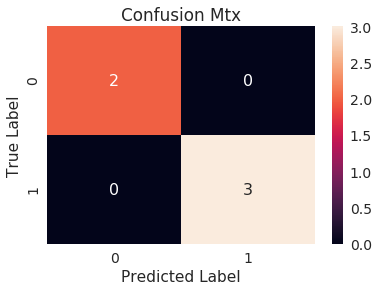

In [39]:
#random forest classifier model
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(validation)
custom_evaluation(rf_preds, 'Random Forest')

Gradient Boosted Trees -> PR AUC: 1.0
Gradient Boosted Trees
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


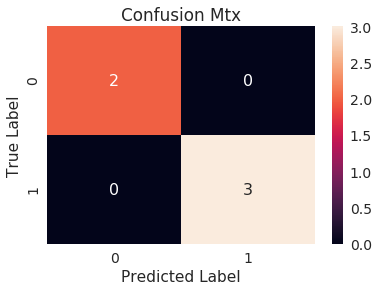

In [40]:
#Gradient boosted trees
gbtrees = GBTClassifier(maxIter=10)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(validation)
custom_evaluation(gbtree_preds, 'Gradient Boosted Trees')

Logistic Regression -> PR AUC: 1.0
Logistic Regression
 | precision = 0.4
 | recall = 0.4
 | F1-Score = 0.4


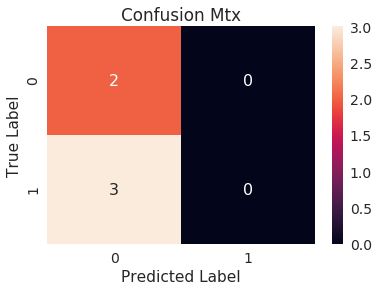

In [41]:
#logistic regression model
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)
custom_evaluation(lr_preds, 'Logistic Regression')

Support Vector Machine -> PR AUC: 1.0
Support Vector Machine
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


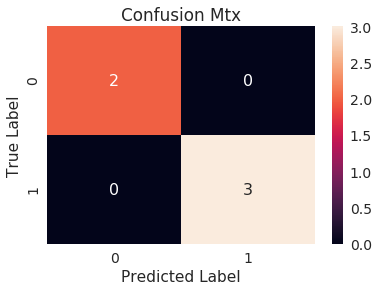

In [42]:
#SVM
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
custom_evaluation(svm_preds, 'Support Vector Machine')

In [57]:
#visual check for predictions
for x in [svm_preds, lr_preds, gbtree_preds, rf_preds]:
    x.select('features', 'rawPrediction', 'prediction', 'label').show()

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,1.0,0.315068...|[-0.9771510091968...|       1.0|  1.0|
|[0.33333333333333...|[-1.4067021398948...|       1.0|  1.0|
|[0.0,1.0,0.054794...|[-1.6442177020221...|       1.0|  1.0|
|[0.33333333333333...|[1.45283571752417...|       0.0|  0.0|
|[0.0,0.0,0.082191...|[1.13995243762261...|       0.0|  0.0|
+--------------------+--------------------+----------+-----+

+--------------------+--------------------+----------+-----+
|            features|       rawPrediction|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.0,1.0,0.315068...|[0.29836075425595...|       0.0|  1.0|
|[0.33333333333333...|[0.29836075425595...|       0.0|  1.0|
|[0.0,1.0,0.054794...|[0.29836075425595...|       0.0|  1.0|
|[0.33333333333333...|[1.86307471057955...|       0.0|  0.0|
|[0.0,0.0,0.082191...|[

In [58]:
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", metricName = 'areaUnderPR')
for x in [svm_preds, lr_preds, gbtree_preds, rf_preds]:
    print(x,evaluator.evaluate(x))

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector, rawPrediction: vector, prediction: double] 1.0
DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double] 1.0
DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dail

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.